In [350]:
import numpy as np
import scipy as sp
import sklearn as skl
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from skimage.transform import resize
import matplotlib as mpl
import matplotlib.pyplot as plt
import zipfile as zf
import pandas as pd
# import cv2
import PIL as pil

In [2]:
archive = zf.ZipFile('data/archive.zip')

In [3]:
metafile  = archive.open('Meta.csv')
testfile  = archive.open('Test.csv')
trainfile = archive.open('Train.csv')

In [4]:
meta  = pd.read_csv(metafile)
test  = pd.read_csv(testfile)
train = pd.read_csv(trainfile)

In [335]:
train_images = [ mpl.image.imread(archive.open(imfile)) for imfile in train.Path]
train_labels = np.array(train.ClassId)

test_images = [ mpl.image.imread(archive.open(imfile)) for imfile in test.Path]
test_labels = np.array(test.ClassId)

In [338]:
def PCA(data):
    ''' 
    Perform Principal Component Analysis on input matrix. Input matrix should be
    a 2d matrix that represents all train data for a given class, such that each 
    row represents one flattened image from the dataset. 
    
    Returns eigenvalues and eigenvectors sorted from highest eigenvalue to lowest.
    '''
    
    # Standardize data to mean=0, sd=1
    avg = np.mean(data,axis=0)
    sd = np.std(data,axis=0)
    data = (data-avg)/sd

    # Find the covariance matrix
    cov = np.cov(data)

    # Find eigen-decomposition of cov matrix
    eigenvals, eigenvecs = np.linalg.eig(cov)

    # Make sure they are sorted from highest eigenvalue to lowest
    order = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[order]
    eigenvecs = eigenvecs[:,order]
    
    # Return
    return eigenvals, eigenvecs

def crop(img, crop_to):
    img_shape = np.array(img.shape[:len(crop_to)])
    diff = img_shape - crop_to
    # Split crop amount as evenly as possible btw left/right and btw top/bottom
    trim = diff/2
    split = np.zeros((len(img_shape),2), dtype=int)
    split[...,0] = np.floor(trim)
    split[...,1] = np.ceil(trim)
    # Indices to keep (middle portion of image)
    inds = (split - np.expand_dims(img_shape,1)) * np.array([1,-1]) 
    # Perform crop
    img = img[inds[0,0]:inds[0,1],inds[1,0]:inds[1,1]]
    return img


def get_img_ndims(img):
    # Check if image is 3D. If 2D, assume grayscale. 
    # Also, if last dimension is not of length 3, assume image is 
    # grayscale and any additional leading dimensions describe
    # array of images and should be preserved.
    input_dims = np.ndim(img)
    if input_dims < 3 or img.shape[-1] != 3:
        img_dims = 2
    else: 
        img_dims = 3
        
    return img_dims


def adjust_range(img):
    ''' Handle the fact that some pixel values are outside [0,1] range.'''
    img_dims = get_img_ndims(img)
    pixel_axes = tuple(np.arange(np.ndim(img)-img_dims,np.ndim(img)))
    if np.ptp(img,axis=pixel_axes) < 0.001:
        print(np.ptp(img,axis=pixel_axes))
    rescaled_img  = img/np.ptp(img,axis=pixel_axes)
    rescaled_img -= np.min(rescaled_img,axis=pixel_axes)
    
    return rescaled_img
    
    

def normalize_brightness(img, axis=None):
    avg_brightness = np.mean(img,axis=axis)
    img /= avg_brightness
    return img
   

def deprocess(img, img_size=None):
    if img_size is None:
        img_size = img.shape[-1]
    

def process(img, resize_to=None, flat=True, rgb2gray=False):
    # Resize image to desired size
    if resize_to is not None:
        img = resize(img, crop_to) 
        
    # Rescale image to have all pixel values on [0,1]
    img = adjust_range(img)
    
    if flat:
        img = flatten(img, rgb2gray=rgb2gray)
    return img


# def de_process(img):
#     '''Return data matrix into list of images. '''

 
def flatten(img, rgb2gray=False):
    # Convert image to grayscale first
    if rgb2gray:
        img = np.mean(img,axis=-1)
        
    img = np.ravel(img)
    
    return img
    
#     img_dims = get_img_ndims(img)
#     non_pixel_axes = tuple(np.arange(np.ndim(img)-img_dims,np.ndim(img)))
    
#     # Flatten NxMx3 image into 1D vector of length NxMx3
#     if len(pixel_axes)<=np.ndim(img):
#         img = np.ravel(img)
#     else:
#         img = np.reshape(img, (-1,np.product(pixel_axes)) )
    
#     return img
    

shapes = np.array([im.shape for im in train_images])
resize_to = np.min(shapes,axis=0)
# train_data = np.array([process(img, resize_to=resize_to, flat=True) for img in train_images])
test_data  = np.array([process(img, resize_to=resize_to, flat=True) for img in test_images]) 


In [341]:
train_data.shape

(39209, 1875)

In [304]:
np.ravel(img).shape

(1875,)

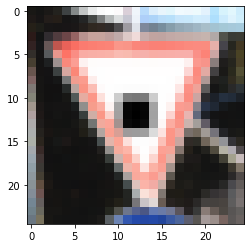

In [299]:
# img = crop(train_images[20909],(25,25,3))
# ptp = np.ptp(img)
# plt.figure()
# plt.imshow(img)
# plt.figure()
# plt.imshow(train_images[20909])

plt.imshow(resize(train_images[20909], (25,25,3)))

In [289]:
np.kron

<function numpy.kron(a, b)>

In [308]:
pca = skl.decomposition.PCA()
pca_train = pca.fit_transform(train_data)

In [309]:
labels = {
    str(i): f"PC {i+1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

In [310]:
labels

{'0': 'PC 1 (31.2%)',
 '1': 'PC 2 (15.9%)',
 '2': 'PC 3 (6.2%)',
 '3': 'PC 4 (4.3%)',
 '4': 'PC 5 (3.5%)',
 '5': 'PC 6 (2.5%)',
 '6': 'PC 7 (2.4%)',
 '7': 'PC 8 (1.8%)',
 '8': 'PC 9 (1.8%)',
 '9': 'PC 10 (1.4%)',
 '10': 'PC 11 (1.3%)',
 '11': 'PC 12 (1.2%)',
 '12': 'PC 13 (1.0%)',
 '13': 'PC 14 (0.9%)',
 '14': 'PC 15 (0.8%)',
 '15': 'PC 16 (0.8%)',
 '16': 'PC 17 (0.7%)',
 '17': 'PC 18 (0.6%)',
 '18': 'PC 19 (0.6%)',
 '19': 'PC 20 (0.6%)',
 '20': 'PC 21 (0.5%)',
 '21': 'PC 22 (0.5%)',
 '22': 'PC 23 (0.4%)',
 '23': 'PC 24 (0.4%)',
 '24': 'PC 25 (0.4%)',
 '25': 'PC 26 (0.4%)',
 '26': 'PC 27 (0.4%)',
 '27': 'PC 28 (0.4%)',
 '28': 'PC 29 (0.3%)',
 '29': 'PC 30 (0.3%)',
 '30': 'PC 31 (0.3%)',
 '31': 'PC 32 (0.3%)',
 '32': 'PC 33 (0.3%)',
 '33': 'PC 34 (0.3%)',
 '34': 'PC 35 (0.3%)',
 '35': 'PC 36 (0.3%)',
 '36': 'PC 37 (0.3%)',
 '37': 'PC 38 (0.2%)',
 '38': 'PC 39 (0.2%)',
 '39': 'PC 40 (0.2%)',
 '40': 'PC 41 (0.2%)',
 '41': 'PC 42 (0.2%)',
 '42': 'PC 43 (0.2%)',
 '43': 'PC 44 (0.2%)',
 '44'

In [93]:
pca_train.shape

(39209, 1875)

In [311]:
pca_train_reshaped = np.reshape(pca_train,(-1,25,25,3))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


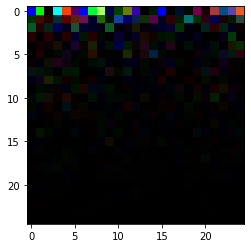

In [313]:
img = pca_train_reshaped[0]
plt.imshow(img)

In [330]:
img = pca_train[0]
img_size = img.shape[-1]

In [332]:


grayscale=False

# Do your best to make a square-ish image
if grayscale:
    print("grayscale deprocessing unimplemented")
else:
    px = img.size/3
    dim1 = int(np.ceil(np.sqrt(px)))
    dim2 = int(np.floor(np.sqrt(px)))
    img = np.reshape(img, (dim1,dim2,3))

img = adjust_range(img)    


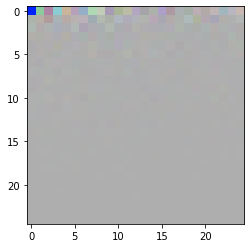

In [333]:
plt.imshow(img)

In [343]:
dtree = DecisionTreeClassifier()

dtree.fit(pca_train, train_labels)


pca_test = pca.transform(test_data)

# predict labels using the trained classifier
predicted_test_labels = dtree.predict(pca_test)

In [344]:
predicted_test_labels

array([16, 34, 38, ...,  2,  5,  9])

In [351]:
cm = confusion_matrix(test_labels, predicted_test_labels)

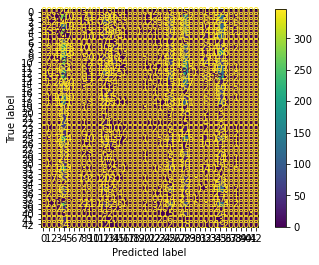

In [353]:
plot_confusion_matrix(dtree, test_data, test_labels)

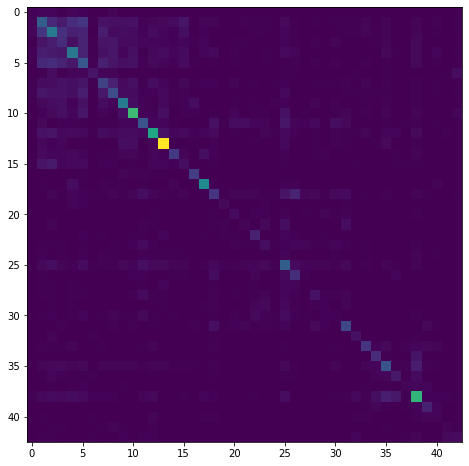

In [356]:
plt.figure(figsize=(8,8))
plt.imshow(cm)